In [72]:
import numpy as np
from scipy.fft import fft, ifft, fftshift
from sklearn.linear_model import Lasso
import cvxpy as cp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
with open('data_set_1.pkl', 'rb') as f:
    data_set_1 = pickle.load(f)

xvals1 = data_set_1[:, 0]
yvals1 = data_set_1[:, 1]

In [3]:
def xp_mat_maker(xvals, p):
    xp = np.ones((xvals.size, p+1))
    for jj in range(p):
        xp[:, jj+1] = xvals * xp[:, jj]
    return xp

In [4]:
def least_squares_solve(mat, yvals):
    u, s, vt = np.linalg.svd(mat, full_matrices=False)
    alpha = (vt.T @ np.diag(1./s) @ u.T) @ yvals.reshape(-1, 1)
    error = np.linalg.norm(mat @ alpha - yvals.reshape(-1, 1))**2./(2.*yvals.size)
    return alpha, error 

In [5]:
def cross_fold(alpha, xvals, yvals, pval, kfolds):

    kf = KFold(n_splits=kfolds)
    w_avg = np.zeros(pval+1)
    errors = np.zeros(kfolds)
    cnt = 0

    for train, test in kf.split(xvals):
        xtrain, ytrain = xvals[train], yvals[train]
        xtest, ytest = xvals[test], yvals[test]
        xp_train = xp_mat_maker(xtrain, pval)        
        res = Lasso(alpha, max_iter=16000, tol=1e-4).fit(xp_train, ytrain) # alpha > 0
        w_lasso = res.coef_
        w_avg += w_lasso
        
        xp_test = xp_mat_maker(xtest,pval)
        errors[cnt] = np.linalg.norm(xp_test @ w_lasso.reshape(-1,1) - ytest)/np.sqrt(2.*ytest.size)
        cnt += 1
        
    error = np.mean(errors)
    var = np.std(errors)
    return w_avg/kfolds, error, var

## Overdetermined problems, data scaling, Regression with LASSO

Throughout this subsection, we look at the optimization problem

$$
{\bf x}_{\ast} = \text{arg min}_{{\bf x}}\left|\left|A{\bf x} - {\bf b}\right|\right|^{2}_{2} + \lambda \left|\left|{\bf x}\right|\right|_{1}, ~ \lambda > 0
$$

As we have shown, if we take $A$ to be orthogonal, we have the affiliated critical point problem:
$$
\partial_{x_{k}}\sum_{j}\left(x_{j}^{2} - 2u_{j}x_{j} + \lambda |x_{j}|  \right) = 0
$$
where ${\bf u} = A^{T}{\bf b}$.  Using the definition of the sub-differential of the absolute value function which is:
$$
\partial|x| = \left\{
\begin{array}{rl}
1 & x \gt 0 \\ 
-1 & x \lt 0 \\ 
r & x = 0
\end{array}
\right.
$$
with $-1 < r < 1$.  Thus our critical point problem becomes 
$$
x_{k} - u_{k} + \frac{\lambda}{2}\partial_{x_{k}}|x_{k}| = 0,
$$
which then has the solution
$$
x_{k} = \left\{
\begin{array}{rl}
u_{k} - \frac{\lambda}{2} & u_{k}\gt\frac{\lambda}{2}\\
0 & -\frac{\lambda}{2} \leq u_{k} \leq \frac{\lambda}{2}\\
u_{k} + \frac{\lambda}{2} & u_{k}\lt-\frac{\lambda}{2}
\end{array}
\right.
$$

This serves as our first hint that the l1-penalization term promotes sparsity in our solution.  Now let's see it in action.  

First, for our chosen data set, we rescale by subtracting the mean and scaling by the standard deviation.  This is very common practice, though we note different scalings can produce different results.  

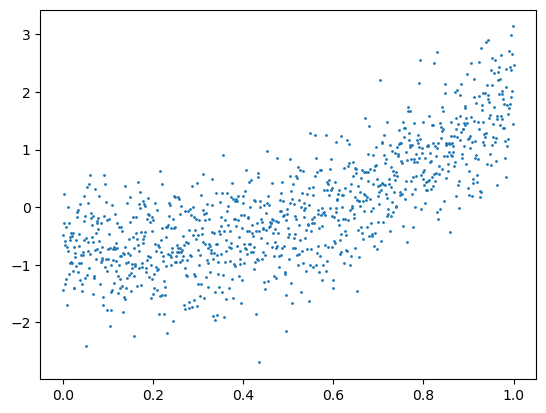

In [6]:
# rescale data
xmax = np.max(xvals1)
ymean = np.mean(yvals1)
ystd = np.std(yvals1)

xvalsrsc = xvals1/xmax
yvalsrsc = (yvals1-ymean)/ystd

plt.scatter(xvalsrsc, yvalsrsc, s=1.)

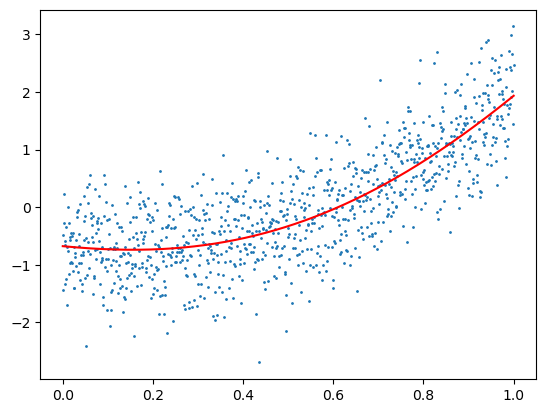

In [7]:
pval = 4
xp = xp_mat_maker(xvalsrsc, pval)
alpha, error = least_squares_solve(xp, yvalsrsc)
yfit = xp @ alpha.reshape(-1,1)
plt.plot(xvalsrsc, yfit, color='r')
plt.scatter(xvalsrsc, yvalsrsc, s=1.)

Note, if we add our scaling terms back in to our fit, we see it's as good as when applied the fit to scaled data.  So that's nice.  

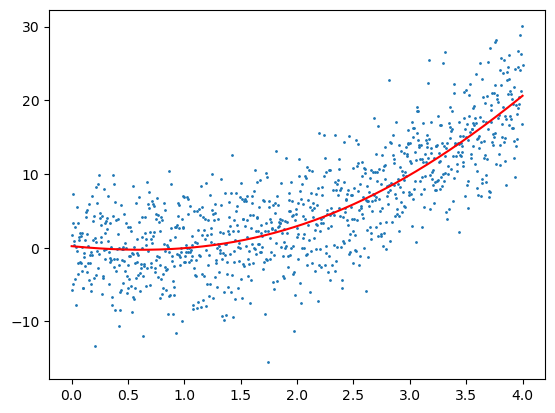

In [8]:
yfit = ystd*yfit + ymean
plt.plot(xvals1,yfit,color='r')
plt.scatter(xvals1, yvals1, s=1.)

Now let's perform a 50-kfold crossvalidation test of LASSO fits to the data.  Again, in the end, we're interested in which penalization value (represented by $\lambda$) gets us both an accurate but also relatively sparse solution.  

In [9]:
numlams = 30
lampows = np.linspace(-6., 0, numlams) # choices, choices
errors = np.zeros(lampows.size)
stds = np.zeros(lampows.size)
pval = 10
kfolds = 50

avalsvslam = np.zeros((pval+1, numlams))
for jj, lampow in enumerate(lampows):
    lam = 10**(lampow)    
    w_avg, mean, std = cross_fold(lam, xvalsrsc, yvalsrsc, pval, kfolds)
    avalsvslam[:, jj] = w_avg
    errors[jj] = mean
    stds[jj] = std

/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+02, tolerance: 9.851e-02
  model = cd_fast.enet_coordinate_descent(
/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+02, tolerance: 9.867e-02
  model = cd_fast.enet_coordinate_descent(
/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Text(0, 0.5, 'Mean Error')

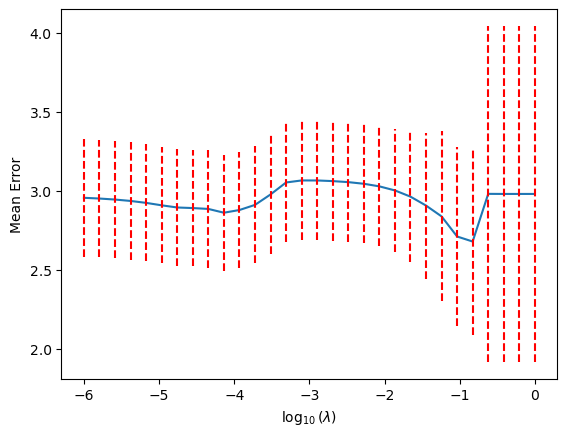

In [10]:
plt.plot(lampows, errors) # how would you plot the standard devations as error bars around the mean of the error?
for jj in range(stds.size):
    ejp = errors[jj] + stds[jj]
    ejm = errors[jj] - stds[jj]
    plt.plot([lampows[jj], lampows[jj]], [ejm, ejp], ls='--', c='r')
plt.xlabel(r"$\log_{10}(\lambda)$");
plt.ylabel(r"Mean Error")

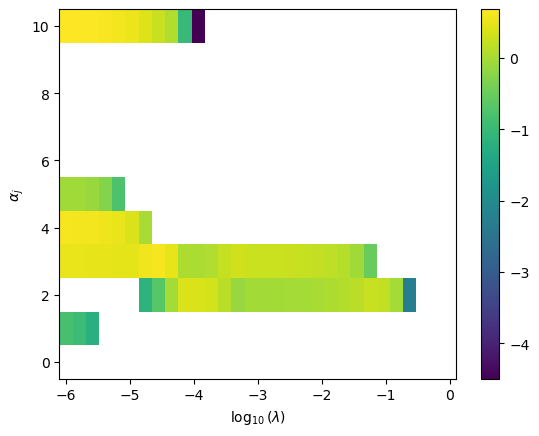

In [11]:
cfig = plt.pcolormesh(lampows, np.arange(pval+1), np.ma.log10(avalsvslam))
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel(r"$\alpha_{j}$")
plt.colorbar(cfig);

So as we can see, as we move towards lower error, we also move to a sparse solution which exactly picks out the single quadratic term that we would expect.  

## Underdetermined Problems and Finding Overcomplete Libraries.  

Now let's look at the related problem of finding 

$$
\boldsymbol{\alpha}_{\ast} = \text{arg min}_{\boldsymbol{\alpha}}\left|\left|\boldsymbol{\alpha}\right|\right|_{1}, ~ \text{s.t.~} \frac{1}{2m}\left|\left|A\boldsymbol{\alpha}-{\bf b}\right|\right|_{2}^{2} \lt \epsilon
$$

where $A$ is underdetermined such that if $A$ is $m\times n$ then $m < n$.  Note, while we've been discussing $A\boldsymbol{\alpha}={\bf b}$ in class, given that our data has noise, we need to relax the equality constraint to the inequality you see above.  Overfitting is still a thing afterall, and we do need to think about what happens when we change the parameter $\epsilon>0$.    

Note, as a constrained optimization problem, clearly this is similar to the one above since its affiliated Lagrangian is given by 
$$
\mathcal{L}(\boldsymbol{\alpha}) = \left|\left|\boldsymbol{\alpha}\right|\right|_{1} + \frac{\lambda}{2m} \left|\left|A\boldsymbol{\alpha}-{\bf b}\right|\right|_{2}^{2}
$$
but ultimately we need a new software tool by way of the `cvxpy` library.  

In [12]:
def xp_trig_mat_maker(xvals, p, ovals):
    
    xp = np.ones((xvals.size, p + 1 + 2*ovals.size))
    for jj in range(p):
        xp[:, jj+1] = xvals * xp[:, jj]
    xv_times_ov = xvals[:, np.newaxis] @ ovals[np.newaxis, :]
    xp[:, p + 1 : p + 1 + ovals.size] = np.cos(xv_times_ov)
    xp[:, p + 1 + ovals.size: p + 1 + 2*ovals.size] = np.sin(xv_times_ov)
    return xp

In [13]:
with open('data_set_2.pkl', 'rb') as f:
    data_set_2 = pickle.load(f)

xvals2 = data_set_2[:, 0]
yvals2 = data_set_2[:, 1] + 3.*xvals2**2 + 4. 

1001


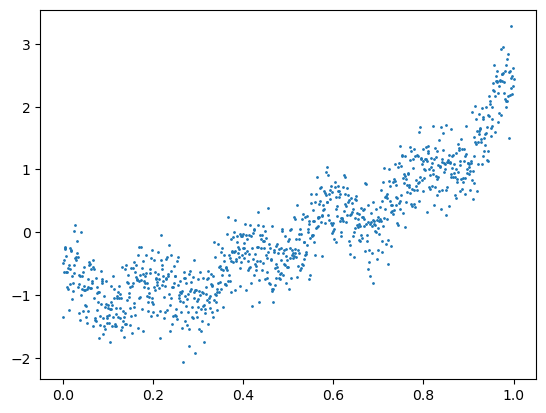

In [14]:
# rescale data
xmax = np.max(xvals2)
ymean = np.mean(yvals2)
ystd = np.std(yvals2)

xvalsrsc = xvals2/xmax
yvalsrsc = (yvals2-ymean)/ystd
print(yvalsrsc.size)

plt.scatter(xvalsrsc, yvalsrsc, s=1.)

Now, let's suppose one part of our model is through polynomials $x^{j}$ up to $j=10$, while the next part is trig funcitons of the form $\cos(2\pi nx)$, $\sin(2\pi nx)$ up to $n=100$.

In [15]:
# Build our big underdetermined model

pval = 11
ovals = 2.*np.pi*np.arange(100)

# So our model is going to be 220 columns wide.  
# Downsample for underdetermined problem.

xvalsdwnsmpl = xvalsrsc[::20]
yvalsdwnsmpl = yvalsrsc[::20]

A_mat = xp_trig_mat_maker(xvalsdwnsmpl, pval, ovals)
print(A_mat.shape)

(51, 212)


Now, we will make use of the `cvxpy` library which allows for the statement of our problem in very straightforward code.  

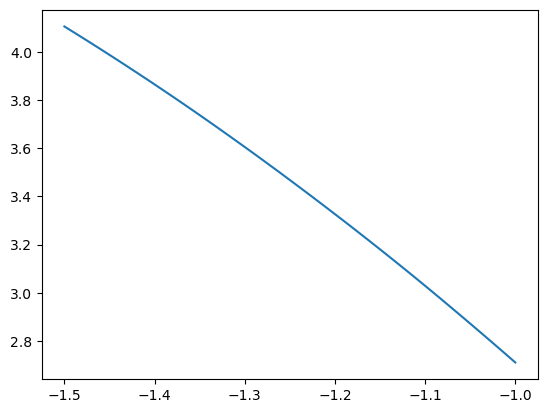

In [73]:
alpha = cp.Variable(A_mat.shape[1])
ep = cp.Parameter(nonneg=True)
objective = cp.Minimize(cp.norm(alpha, 1))
constraint = [cp.sum_squares(A_mat@alpha-yvalsdwnsmpl)/(2.*A_mat.shape[0]) <= ep]
prob = cp.Problem(objective, constraint)

l1_penalty = []
alpha_values = []
ep_vals = np.logspace(-1.5, -1)
for eval in ep_vals:
    ep.value = eval
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    l1_penalty.append(cp.norm(alpha, 1).value)
    alpha_values.append(alpha.value)

plt.plot(np.log10(ep_vals), l1_penalty)

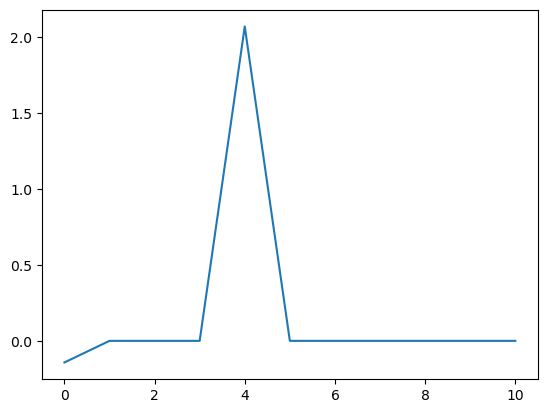

In [74]:
mchoice_index = 0
plt.plot(alpha_values[mchoice_index][:pval])

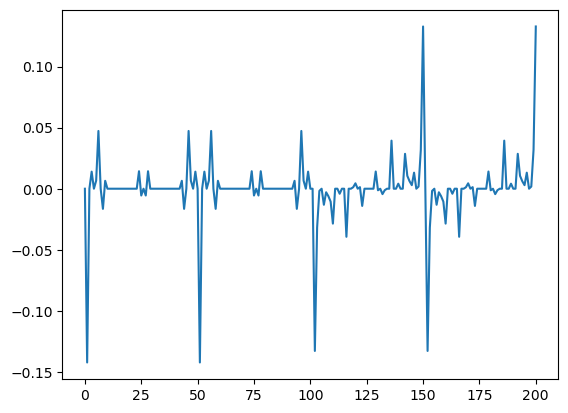

In [75]:
plt.plot(alpha_values[mchoice_index][pval:])

So, as we see in the plot, the solver only finds a very limited number of terms.  Frustratingly, it keeps latching onto $x^{4}$ as the primary polynomial term, and it does leave us with quite a few harmonics to sort out.  That all said, if we then look at what happens when we use this as an actual fit, we find the following.  

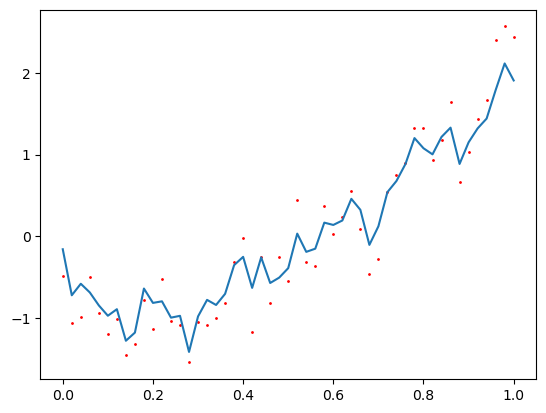

In [76]:
plt.plot(xvalsdwnsmpl, A_mat @ alpha_values[mchoice_index])
plt.scatter(xvalsdwnsmpl, yvalsdwnsmpl, c='r', s=1.)

### Finding overcomplete dictionaries via $l_2$ minimization.

So, while our $l_1$ based approach has its ups and downs, we should keep in mind that much of this work is motivated by avoiding what happens if we only use the related approach

$$
\boldsymbol{\alpha}_{\ast} = \text{arg min}_{\boldsymbol{\alpha}}\left|\left|\boldsymbol{\alpha}\right|\right|_{2}, ~ \text{s.t.~} \frac{1}{2m}\left|\left|A\boldsymbol{\alpha}-{\bf b}\right|\right|_{2}^{2} \lt \epsilon
$$

So let's rerun our experiments from above, but now just using this more classical approach.  

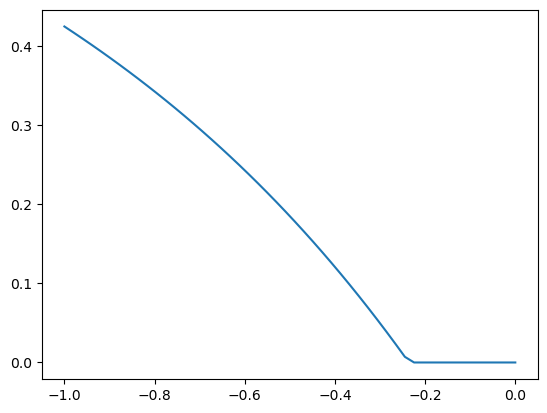

In [77]:
l2_alpha = cp.Variable(A_mat.shape[1])
l2_ep = cp.Parameter(nonneg=True)
l2_objective = cp.Minimize(cp.norm(l2_alpha, 2))
l2_constraint = [cp.sum_squares(A_mat@l2_alpha-yvalsdwnsmpl)/(2.*A_mat.shape[0]) <= l2_ep]
l2_prob = cp.Problem(l2_objective, l2_constraint)

l2_penalty = []
l2_alpha_values = []
ep_vals = np.logspace(-1., 0.)
for eval in ep_vals:
    l2_ep.value = eval
    l2_prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    l2_penalty.append(cp.norm(l2_alpha, 2).value)
    l2_alpha_values.append(l2_alpha.value)

plt.plot(np.log10(ep_vals), l2_penalty)

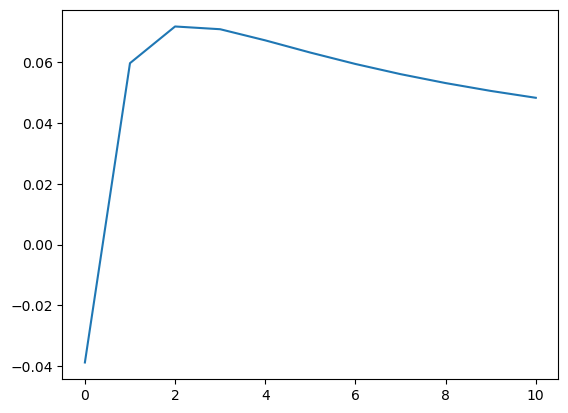

In [78]:
mchoice_index = 0
plt.plot(l2_alpha_values[mchoice_index][:pval])

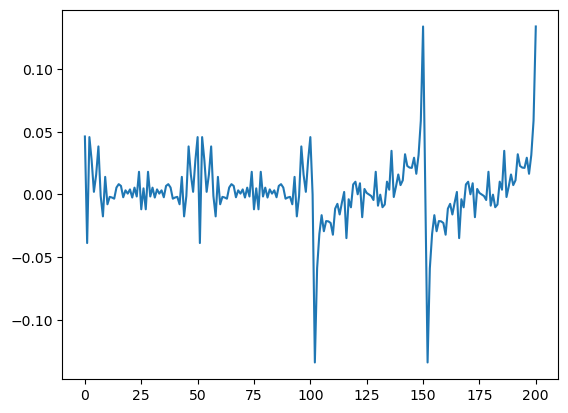

In [79]:
plt.plot(l2_alpha_values[mchoice_index][pval:])

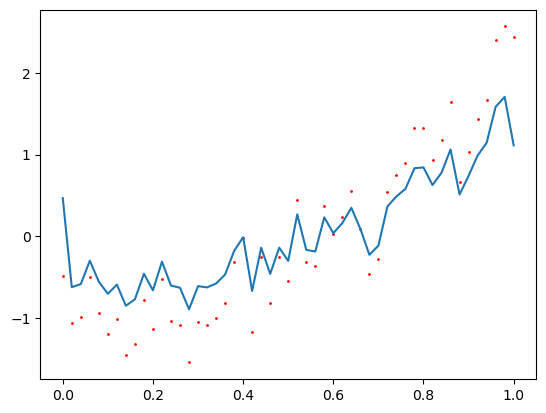

In [80]:
plt.plot(xvalsdwnsmpl, A_mat @ l2_alpha_values[mchoice_index])
plt.scatter(xvalsdwnsmpl, yvalsdwnsmpl, c='r', s=1.)